In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer

import os
import operator
import warnings
import gensim
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

Načítame trénovaciu aj testovaciu vzroku. Trénovacia vzorka sa ešte rozdelí na validačnu.

In [2]:
train_data = pd.read_csv('../input/kernel9f97ac1908/train_data.csv')
test_data = pd.read_csv('../input/kernel9f97ac1908/test_data.csv')

Celý postup preprocesingu som zhrnul do jednej triedy. Funkciou preprocess_train_test dostanem spracovaný vstup pre sklearn modely, funkciou preprocess_nn_train_test dostanem spracovaný vstup pre neurónovú sieť.

In [3]:
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

class Preprocessor():
    
    def __init__(self):
        en_stopwords = stopwords.words('english')
        self.stemmer = SnowballStemmer('english')
        self.stops = set(stopwords.words('english'))
        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.label_encoder = LabelEncoder()
        self.tfidfVectorizer = TfidfVectorizer(ngram_range=(1,1))
        MAX_NUM_WORDS = 40000
        self.chi2_model = SelectKBest(chi2, k=MAX_NUM_WORDS);
        self.tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, char_level=False)
    
    def common_preprocess(self, X_train, X_test, y_train, y_test):
        self.y_train = self.label_encoder.fit_transform(y_train)
        self.y_test = self.label_encoder.transform(y_test)
        
        self.X_train_lemmatized = self.lematize_preprocess(X_train)
        self.X_test_lemmatized = self.lematize_preprocess(X_test)
    
    def preprocess_train_test(self, X_train, X_test, y_train, y_test):
        self.common_preprocess(X_train, X_test, y_train, y_test)
        
        self.X_train_vect = self.tfidfVectorizer.fit_transform(self.X_train_lemmatized)
        self.X_test_vect  = self.tfidfVectorizer.transform(self.X_test_lemmatized)
        
        self.X_train_chi2 = self.chi2_model.fit_transform(self.X_train_vect, self.y_train)
        self.X_test_chi2 = self.chi2_model.transform(self.X_test_vect)
        
        return self.X_train_chi2, self.X_test_chi2, self.y_train, self.y_test
    
    def preprocess_nn_train_test(self, X_train, X_test, y_train, y_test):
        self.common_preprocess(X_train, X_test, y_train, y_test)

        self.y_train_cat = to_categorical(np.asarray(self.y_train))
        self.y_test_cat = to_categorical(np.asarray(self.y_test))
        
        self.tokenizer.fit_on_texts(self.X_train_lemmatized)

        self.X_train_sequence = self.tokenizer.texts_to_sequences(self.X_train_lemmatized)
        self.X_test_sequence = self.tokenizer.texts_to_sequences(self.X_test_lemmatized)

        MAX_SEQUENCE_LENGTH = 500

        self.X_train_pad = pad_sequences(self.X_train_sequence, maxlen=MAX_SEQUENCE_LENGTH)
        self.X_test_pad = pad_sequences(self.X_test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
        
        return self.X_train_pad, self.X_test_pad, self.y_train_cat, self.y_test_cat
        
    def lematize_preprocess(self, X):
        def preprocess_text(texts, wordnet_lemmatizer, stops):
            texts = gensim.utils.simple_preprocess(texts, deacc=True, min_len=3)
            texts = [word for word in texts if word not in stops]
            texts = [wordnet_lemmatizer.lemmatize(word) for word in texts]
            return " ".join(texts)
        
        return X.apply(lambda x: preprocess_text(x, self.wordnet_lemmatizer, self.stops))
    
    def stem_preprocess(self, X):
        def stem_preprocess(X, stemmer, stops):
            X = gensim.utils.simple_preprocess(X, deacc=True, min_len=3)
            X = [word for word in X if word not in stops]
            X = [stemmer.stem(word) for word in X]
            return " ".join(X)

        return X.apply(lambda x: preprocess_text(X, self.stemmer, self.stops))
    


Using TensorFlow backend.


Predspracovanie trénovacej vzorky a jej rozdelenie na validčnú.

In [4]:
preprocessor = Preprocessor()
X = train_data['job_description']
y = train_data['category']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = preprocessor.preprocess_train_test(X_t, X_v, y_t, y_v)


pomocné funkcie na vypísanie úspešnosti modelov, confusion matrix:

In [5]:
from sklearn.metrics import classification_report

def fit(model, X, y):
    return model.fit(X, y)

def predict(model, X, y, matrix=False):
    y_predicted = model.predict(X)
    print('f1 score:',f1_score(y_predicted, y, average='weighted'))
    print('accuracy_score:',accuracy_score(y_predicted, y))
    return y_predicted, y

def showClassReport(ax,le, y_predicted, y_true, color='b'):
    def classification_report_csv(report):
        report_data = []
        lines = report.split('\n')
        for line in lines[2:-3]:
            row = {}
            row_data = line.split(' ') 
            row_data = list(filter(None, row_data))
            if len(row_data) == 5:
                row['class'] = le.inverse_transform([int(row_data[0])])[0]
                row['precision'] = float(row_data[1])
                row['recall'] = float(row_data[2])
                row['f1_score'] = float(row_data[3])
                row['support'] = float(row_data[4])
                report_data.append(row)
        return pd.DataFrame.from_dict(report_data)

    report = classification_report(y_predicted, y_true)
    precisions = classification_report_csv(report).sort_values(by=['class'])['precision']
    counts = train_data['category'].value_counts()
    print(np.corrcoef(precisions , counts))
    classification_report_csv(report).sort_values(by=['class']).plot(
        ax=ax,
        kind='bar', y='precision', x='class', figsize=(15,4), sort_columns=True, 
        color=color, alpha=0.3
    )
    
def showConfusionMatrix(y_true, y_predicted, le):
    cnf_matrix = confusion_matrix(y_true, y_predicted)
    np.set_printoptions(suppress=True, precision=2)
    df_cm = pd.DataFrame(cnf_matrix, index = [i for i in le.classes_],
                      columns = [i for i in le.classes_])
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, fmt='g')
    np.set_printoptions(suppress=False)

<h2>Trénovanie modelov</h2>
<p>Hyperparametre všetkých modelov boli nájdene pomocou grid searchu. Kvoli prehľadnsti modely obsahujú už najlepšie hyperparametre.

<h2>Dummy classifier</h2>
<p>Sklearn ponúka tzv. Dummy classifier, ktorý generuje náhodne predikcie. Často je to dobrý spôsob ako si určiť spodnú hranicu úspešnosti skutočných modelov. Používa sa stratégia stratified, ktorá predikuje triedy v rovnakom pomere ako je ich distribucia.

In [18]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='stratified')
dcm = dc.fit(X_train, y_train)
predict(dcm, X_train, y_train)
predict(dcm, X_val, y_val)

f1 score: 0.03031236420961597
accuracy_score: 0.03028125
f1 score: 0.031404693042708404
accuracy_score: 0.031375


(array([30, 29,  9, ..., 26,  2, 33]), array([ 9, 28,  0, ...,  5, 29,  9]))

<h3>Random forrest</h3>

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfcClf = RandomForestClassifier(n_estimators=150,max_depth=35, random_state=35, n_jobs=-1)
rfcModel = fit(rfcClf, X_train, y_train)

In [20]:
predict(rfcModel, X_train, y_train)
predict(rfcModel, X_val, y_val, True)

f1 score: 0.9809575439832882
accuracy_score: 0.98096875
f1 score: 0.7820241168337454
accuracy_score: 0.776875


(array([ 9, 28,  2, ...,  5, 29,  9]), array([ 9, 28,  0, ...,  5, 29,  9]))

<h2>Lineárne SVM</h2>

In [21]:
linSVCclf = LinearSVC(C=0.8, penalty='l2', dual=True, loss='hinge', class_weight='balanced')
linSVCmodel = fit(linSVCclf, X_train, y_train)

In [22]:
predict(linSVCmodel, X_train, y_train)
predict(linSVCmodel, X_val, y_val, True)

f1 score: 0.9137299525391614
accuracy_score: 0.91325
f1 score: 0.8029967893119885
accuracy_score: 0.80125


(array([ 9, 28, 11, ...,  5, 29,  9]), array([ 9, 28,  0, ...,  5, 29,  9]))

<h2>Logistická regresia</h2>

In [23]:
from sklearn.linear_model import LogisticRegression
lrclf = LogisticRegression(penalty='l2',C=0.8, random_state=0, solver='saga', multi_class='multinomial', n_jobs=-1, class_weight='balanced')
lrModel = fit(lrclf, X_train, y_train)


In [24]:
predict(lrclf, X_train, y_train)
predict(lrclf, X_val, y_val, True)

f1 score: 0.8305314537258265
accuracy_score: 0.83134375
f1 score: 0.7718306792028017
accuracy_score: 0.77375


(array([ 9, 28, 35, ...,  5, 29,  9]), array([ 9, 28,  0, ...,  5, 29,  9]))

<h2>Predspracovanie textu pre NN</h2>
<p> Predspracovaný text pre NN si vyžaduje iný formát</p>

In [25]:
X = train_data['job_description']
y = train_data['category']
preprocessor2 = Preprocessor()
X_train_nn, X_val_nn, y_train_nn, y_val_nn = preprocessor2.preprocess_nn_train_test(X_t, X_v, y_t, y_v)

<h2>Vytvorenie NN</h2>
<p>Funkcia createNN vytvorí a vráti neurónovú sieť. Má dva parametre N_CLASSES - určuje počet neurónov výstupnej vrstvy - počet kategórií do ktorých sa popisy práce rozdeľujú. MAX_SEQUENCE_LENGTH - určuje počet neurónov vstupnej vrstvy - veľkosť vektorov do ktorého bol zakódovaný popis práce.</p>

In [33]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras.optimizers import Adam

def createNN(N_CLASSES, MAX_SEQUENCE_LENGTH=500):
    EMBEDDING_DIM = 64
    MAX_NB_WORDS = 40000

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    embedded_sequences = embedding_layer(sequence_input)

    average = GlobalAveragePooling1D()(embedded_sequences)
    predictions = Dense(N_CLASSES, activation='softmax')(average)

    model = Model(sequence_input, predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.004), metrics=['acc'])
    return model
nn = createNN(len(set(y)))

In [ ]:
nn.summary()

<h2>Ténovanie NN</h2>
<p>Implementácia early stopping, ktorá zastaví trénovanie neurónovej siete, ak sa po niekoľkých etapách nezlepší skóre na validačnej vzorke - predáchza sa tým overfitting.</p>

In [34]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.005, patience=3, verbose=0, mode='auto')

history = nn.fit(X_train_nn, y_train_nn, validation_split=0.1,
          nb_epoch=200, batch_size=256, callbacks=[early_stopping])

Train on 28800 samples, validate on 3200 samples
Epoch 1/200
28800/28800 [==============================] - 2s 79us/step - loss: 3.4485 - acc: 0.1471 - val_loss: 3.2433 - val_acc: 0.2953
Epoch 2/200
28800/28800 [==============================] - 1s 46us/step - loss: 2.8802 - acc: 0.4008 - val_loss: 2.5009 - val_acc: 0.4928
Epoch 3/200
28800/28800 [==============================] - 1s 46us/step - loss: 2.1344 - acc: 0.5698 - val_loss: 1.8667 - val_acc: 0.6178
Epoch 4/200
28800/28800 [==============================] - 1s 47us/step - loss: 1.6156 - acc: 0.6597 - val_loss: 1.4968 - val_acc: 0.6791
Epoch 5/200
28800/28800 [==============================] - 1s 46us/step - loss: 1.3115 - acc: 0.7146 - val_loss: 1.2832 - val_acc: 0.7094
Epoch 6/200
28800/28800 [==============================] - 1s 46us/step - loss: 1.1218 - acc: 0.7478 - val_loss: 1.1570 - val_acc: 0.7284
Epoch 7/200
28800/28800 [==============================] - 1s 46us/step - loss: 0.9913 - acc: 0.7703 - val_loss: 1.0692 - v

<p>Graf vývoja presnosti na trénovacej a validčnej vzorke.</p>

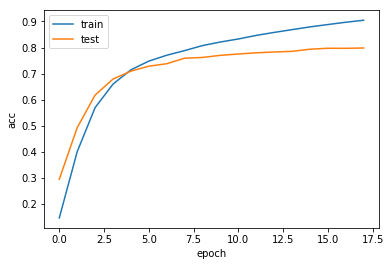

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='upper left')

<h2>Vyhodnotenie NN</h2>

In [36]:
def predictNN(model, X, y):
    y = np.argmax(y, axis=1)
    predicted_y = np.argmax(model.predict(X), axis=1)
    print('f1 score:',f1_score(predicted_y, y, average='weighted'))
    print('accuracy_score:',accuracy_score(predicted_y, y))
    return predicted_y, y
    
predictNN(nn, X_train_nn, y_train_nn)
predictNN(nn, X_val_nn, y_val_nn)

f1 score: 0.9021265748186598
accuracy_score: 0.9019375
f1 score: 0.7961342049639568
accuracy_score: 0.795375


(array([ 9, 28, 20, ...,  5, 29,  9]), array([ 9, 28,  0, ...,  5, 29,  9]))

<h1>Analýza modelov</h1>
<h2>Classification report</p>
<p>Funkcia showClassReport vykreslí úspešnosť predikovania každej triedy určitým modelom. Modroé stĺpce zobrazujú aké percento triedy sa podarilo úspešne predikovať. Farebné stĺpce slúžia na vizualizáciu distribúcie tried.</p>

f1 score: 0.8029967893119885
accuracy_score: 0.80125
[[1.         0.14933667]
 [0.14933667 1.        ]]


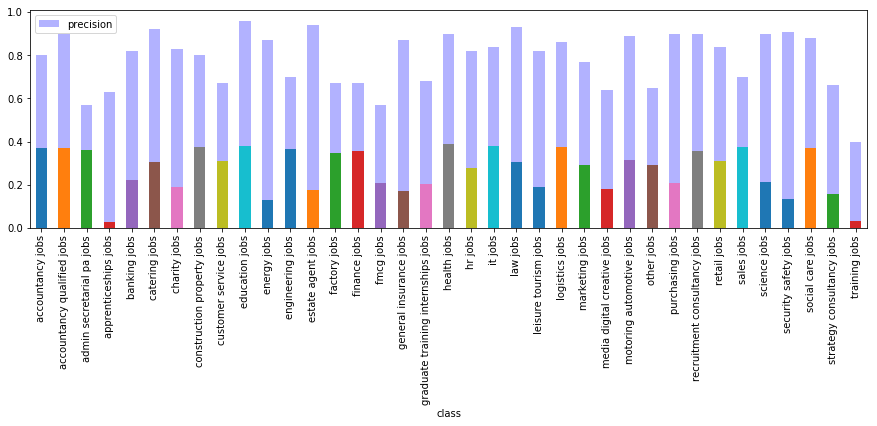

In [45]:
ax = plt.gca()
showClassReport(ax,preprocessor.label_encoder, *predict(linSVCmodel, X_val, y_val), color='b')
((train_data['category'].value_counts() / len(train_data['category']))*10).sort_index().plot(kind='bar', figsize=(15,4), ax=ax)


<p>Porovnanie úspešnosti modelov podľa jednotlivých tried</p>

f1 score: 0.7820241168337454
accuracy_score: 0.776875
[[1.         0.15357535]
 [0.15357535 1.        ]]
f1 score: 0.8029967893119885
accuracy_score: 0.80125
[[1.         0.14933667]
 [0.14933667 1.        ]]
f1 score: 0.7718306792028017
accuracy_score: 0.77375
[[1.         0.02213451]
 [0.02213451 1.        ]]
f1 score: 0.7961342049639568
accuracy_score: 0.795375
[[1.         0.19856002]
 [0.19856002 1.        ]]


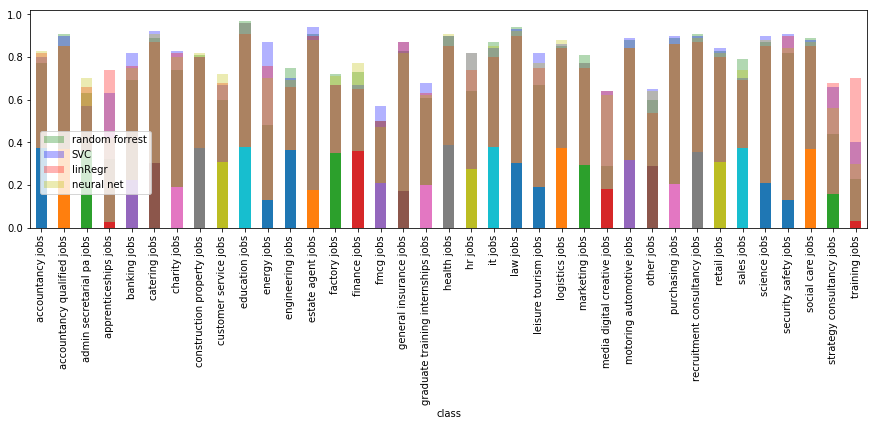

In [37]:
ax = plt.gca()
showClassReport(ax,preprocessor.label_encoder, *predict(rfcModel, X_val, y_val),color='g')
showClassReport(ax,preprocessor.label_encoder, *predict(linSVCmodel, X_val, y_val), color='b')
showClassReport(ax,preprocessor.label_encoder, *predict(lrModel, X_val, y_val), color='r')
showClassReport(ax,preprocessor2.label_encoder,*predictNN(nn, X_val_nn, y_val_nn), color='y')
((train_data['category'].value_counts() / len(train_data['category']))*10).sort_index().plot(kind='bar', figsize=(15,4), ax=ax)
ax.legend(['random forrest', 'SVC', 'linRegr','neural net'], bbox_to_anchor=(0.15, 0.3), loc=5)



<h2>Confusion matrix</p>
<p>Funkcia showConfusionMatrix vykreslí maticu, na ktorej možno vidieť, kde robí model chybu - aké triedy si model zamieňa.</p>

f1 score: 0.7961342049639568
accuracy_score: 0.795375


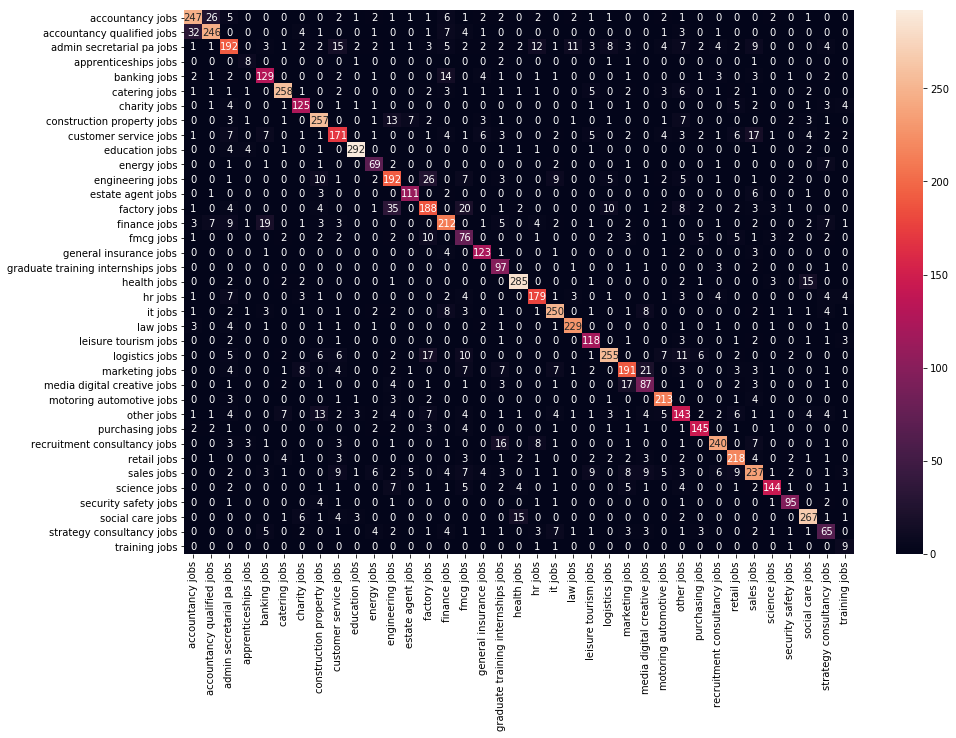

In [50]:
#showConfusionMatrix(*predict(rfcModel, X_val, y_val), preprocessor.label_encoder)
#showConfusionMatrix(*predict(linSVCmodel, X_val, y_val), preprocessor.label_encoder)
#showConfusionMatrix(*predict(lrModel, X_val, y_val), preprocessor.label_encoder)
showConfusionMatrix(*predictNN(nn, X_val_nn, y_val_nn), preprocessor2.label_encoder)

<h2>Soft and hard voting</h2>
<p>Vlastná implementácia hard a soft votingu.</p>
<p>Všetky modely vygenerujú predikciu. Pri hard votinu je finálna predikcia tá trieda, ktorá bola predikovaná najväčším počtom predikátorov. Pri soft votingu sa vygenerujú predikcie aj s pravdepodobnosťami. Finálna predikcia je taká trieda určitého modelu, ktorá bola predpovedaná s najväčšou pravdepodobnosťou.</p>

In [54]:
from scipy import stats
def hardVoting(predictions):
    return stats.mode(predictions).mode[0]

def softVoting(predictions):
    clf_winners = np.argmax(np.max(predictions, axis=2), axis=0)
    pred_y = []
    a = np.argmax(predictions, axis=2).T
    for i in range(a.shape[0]):
        clf_winner = clf_winners[i]
        class_winner = a[i][clf_winner]
        pred_y.append(class_winner)
    return np.array(pred_y)


pred1 = rfcModel.predict_proba(X_train)
pred2 = lrModel.predict_proba(X_train)
pred3 = nn.predict(X_train_nn)#dava priamo pravdepodobnosti
pred4 = linSVCmodel.predict(X_train)

print("trénovacia vzroka:")
y_soft_pred = softVoting(np.array([pred1, pred2, pred3]))
print('soft f1 score:',f1_score(y_soft_pred, y_train, average='weighted'))
print('soft accuracy_score:',accuracy_score(y_soft_pred, y_train))

y_hard_pred = hardVoting([np.argmax(pred1, axis=1), np.argmax(pred2, axis=1), np.argmax(pred3, axis=1), pred4])
print('hard f1 score:',f1_score(y_hard_pred, y_train, average='weighted'))
print('hard accuracy_score:',accuracy_score(y_hard_pred, y_train))

pred1 = rfcModel.predict_proba(X_val)
pred2 = lrModel.predict_proba(X_val)
pred3 = nn.predict(X_val_nn)#dava priamo pravdepodobnosti
pred4 = linSVCmodel.predict(X_val)

print()

print("validačná vzroka:")
y_soft_pred = softVoting(np.array([pred1, pred2,pred3]))
print('soft f1 score:',f1_score(y_soft_pred, y_val, average='weighted'))
print('soft accuracy_score:',accuracy_score(y_soft_pred, y_val))

y_hard_pred = hardVoting([np.argmax(pred1, axis=1), np.argmax(pred2, axis=1), np.argmax(pred3, axis=1), pred4])
print('hard f1 score:',f1_score(y_hard_pred, y_val, average='weighted'))
print('hard accuracy_score:',accuracy_score(y_hard_pred, y_val))


trénovacia vzroka:
[23 33  2 ... 32 35  7] [23 33  2 ... 32 35  7]
soft f1 score: 0.902229633472109
soft accuracy_score: 0.9021875
hard f1 score: 0.9201920431181868
hard accuracy_score: 0.92003125

validačná vzroka:
soft f1 score: 0.7971358943524449
soft accuracy_score: 0.797125
hard f1 score: 0.8049625072851077
hard accuracy_score: 0.804125


<p> Funkcia replaceFieldsOfWork, ktorá v dataframe zlúči podobné oblasti práce.</p> 

In [56]:
def replaceFieldsOfWork(X):
    copy = X.copy()
    #train_data['category'].value_counts().sort_index().plot(kind='bar', figsize=(15,4))
    copy['category'].replace(['accountancy jobs', 'accountancy qualified jobs'], ['accountancy (qualified) jobs', 'accountancy (qualified) jobs'], inplace=True)
    copy['category'].replace(['hr jobs', 'recruitment consultancy jobs'], ['hr/recruitment jobs', 'hr/recruitment jobs'], inplace=True)
    copy['category'].replace(['finance jobs', 'banking jobs'], ['finance/banking jobs', 'finance/banking jobs'], inplace=True)
    return copy

def plotCategories(X):
    X.value_counts().sort_index().plot(kind='bar', figsize=(15,4))

<p>Zlúčia sa podobné kategórie(oblasti práce), znovu sa predstracuj text a rozdelí na validačnú a trénovaciu vzorku</p>

In [57]:

preprocessor3 = Preprocessor()
modified_data = replaceFieldsOfWork(train_data)
X2 = modified_data['job_description']
y2 = modified_data['category']
X_t2, X_v2, y_t2, y_v2 = train_test_split(X2, y2, test_size=0.2)
X_train2, X_val2, y_train2, y_val2 = preprocessor3.preprocess_nn_train_test(X_t2, X_v2, y_t2, y_v2)

<p>Graf distribúcie kategórií po zlúčení podobných</p>

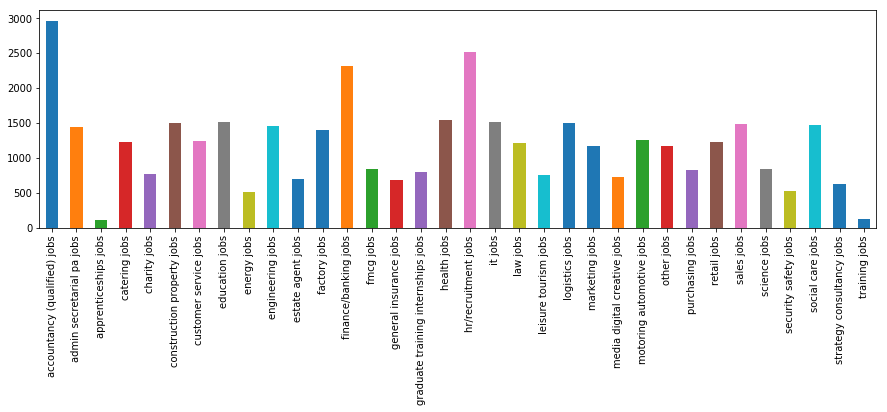

In [58]:
plotCategories(y2)

<p>Vytvorí sa nová neurónová sieť so zmenenou poslednou výstupnou vrstvou</p>

In [59]:
nn2 = createNN(len(set(y2)))

Skóre neurónovej siete po zlúčení niektorých kategórií sa na validčnej vzorke zlepšilo o cca 0.1

In [60]:
from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.002, patience=2, verbose=0, mode='auto')

history = nn2.fit(X_train2, y_train2, validation_split=0.1,
          nb_epoch=200, batch_size=256, callbacks=[early_stopping])

predictNN(nn2, X_train2, y_train2)
predictNN(nn2, X_val2, y_val2)

Train on 28800 samples, validate on 3200 samples
Epoch 1/200
28800/28800 [==============================] - 2s 66us/step - loss: 3.3261 - acc: 0.0994 - val_loss: 3.0970 - val_acc: 0.2147
Epoch 2/200
28800/28800 [==============================] - 1s 45us/step - loss: 2.7506 - acc: 0.3282 - val_loss: 2.3264 - val_acc: 0.4612
Epoch 3/200
28800/28800 [==============================] - 1s 45us/step - loss: 2.0133 - acc: 0.5714 - val_loss: 1.7165 - val_acc: 0.6416
Epoch 4/200
28800/28800 [==============================] - 1s 46us/step - loss: 1.5156 - acc: 0.6795 - val_loss: 1.3651 - val_acc: 0.7200
Epoch 5/200
28800/28800 [==============================] - 1s 46us/step - loss: 1.2297 - acc: 0.7324 - val_loss: 1.1712 - val_acc: 0.7475
Epoch 6/200
28800/28800 [==============================] - 1s 46us/step - loss: 1.0514 - acc: 0.7636 - val_loss: 1.0439 - val_acc: 0.7706
Epoch 7/200
28800/28800 [==============================] - 1s 46us/step - loss: 0.9297 - acc: 0.7848 - val_loss: 0.9673 - v

(array([ 6, 29, 28, ...,  9, 17, 22]), array([ 6, 29, 28, ..., 29, 17, 22]))

<h2>Vyhodnotenie na testovacej vzorke</h2>

Načítaja sa celá trénovacia a testovacai vzorka a predspracuje sa.

In [61]:
train_data_all = replaceFieldsOfWork(train_data)
test_data_all = replaceFieldsOfWork(test_data)

preprocessor4 = Preprocessor()

X_train = train_data_all['job_description']
y_train = train_data_all['category']
X_test = test_data_all['job_description']
y_test = test_data_all['category']
X_train_all, X_test_all, y_train_all, y_test_all = preprocessor4.preprocess_nn_train_test(X_train, X_test, y_train, y_test)

In [63]:
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

((40000, 500), (10000, 500), (40000, 34), (10000, 34))

Vytvorí sa nová neurónova sieť, natrénuje sa na celej trénovacej vzorke a vyhodnotí sa na testovacej vzorke.

In [68]:
nn_test = createNN(len(set(y_train)))

history = nn_test.fit(X_train_all, y_train_all, validation_split=0.1,
          nb_epoch=200, batch_size=128, callbacks=[early_stopping])

predictNN(nn_test, X_train_all, y_train_all)
predictNN(nn_test, X_test_all, y_test_all)

Train on 36000 samples, validate on 4000 samples
Epoch 1/200
36000/36000 [==============================] - 3s 91us/step - loss: 3.0318 - acc: 0.2185 - val_loss: 2.3351 - val_acc: 0.4930
Epoch 2/200
36000/36000 [==============================] - 3s 71us/step - loss: 1.7761 - acc: 0.6176 - val_loss: 1.3853 - val_acc: 0.6957
Epoch 3/200
36000/36000 [==============================] - 3s 71us/step - loss: 1.1807 - acc: 0.7334 - val_loss: 1.0783 - val_acc: 0.7508
Epoch 4/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.9419 - acc: 0.7774 - val_loss: 0.9522 - val_acc: 0.7620
Epoch 5/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.8035 - acc: 0.8051 - val_loss: 0.8725 - val_acc: 0.7815
Epoch 6/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.7038 - acc: 0.8255 - val_loss: 0.8269 - val_acc: 0.7920
Epoch 7/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.6232 - acc: 0.8441 - val_loss: 0.7900 - v

(array([ 9,  8,  3, ..., 19, 11, 25]), array([11,  8,  3, ...,  0, 11, 24]))

Skúsime overiť, či sa model zlepší ak k popisom práce pridáme aj stĺpec "požiadavky" a "názov pracovnej ponuky".

In [69]:
train_data_all = replaceFieldsOfWork(train_data)
test_data_all = replaceFieldsOfWork(test_data)

preprocessor5 = Preprocessor()

train_data_all['job_requirements'] = train_data_all['job_requirements'].fillna('')
test_data_all['job_requirements'] = test_data_all['job_requirements'].fillna('')

X_train = train_data_all['job_description'] + " " + train_data_all['job_requirements'] + " " + train_data_all['job_title']
y_train = train_data_all['category']
X_test = test_data_all['job_description']+ " " +  test_data_all['job_requirements'] + " " + test_data_all['job_title']
y_test = test_data_all['category']
X_train_all, X_test_all, y_train_all, y_test_all = preprocessor5.preprocess_nn_train_test(X_train, X_test, y_train, y_test)

Natrénuje sa nová nn sieť s pridanými stĺpcami. f1 skóre sa zlepší o 0.8.

In [70]:
nn_test = createNN(len(set(y_train)))

history = nn_test.fit(X_train_all, y_train_all, validation_split=0.1,
          nb_epoch=200, batch_size=128, callbacks=[early_stopping])

predictNN(nn_test, X_train_all, y_train_all)
predictNN(nn_test, X_test_all, y_test_all)

Train on 36000 samples, validate on 4000 samples
Epoch 1/200
36000/36000 [==============================] - 3s 95us/step - loss: 2.9658 - acc: 0.2403 - val_loss: 2.1798 - val_acc: 0.5425
Epoch 2/200
36000/36000 [==============================] - 3s 71us/step - loss: 1.6233 - acc: 0.6607 - val_loss: 1.2496 - val_acc: 0.7308
Epoch 3/200
36000/36000 [==============================] - 3s 71us/step - loss: 1.0698 - acc: 0.7576 - val_loss: 0.9926 - val_acc: 0.7648
Epoch 4/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.8590 - acc: 0.7911 - val_loss: 0.8787 - val_acc: 0.7758
Epoch 5/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.7337 - acc: 0.8165 - val_loss: 0.8148 - val_acc: 0.7885
Epoch 6/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.6409 - acc: 0.8373 - val_loss: 0.7705 - val_acc: 0.8027
Epoch 7/200
36000/36000 [==============================] - 3s 71us/step - loss: 0.5655 - acc: 0.8563 - val_loss: 0.7467 - v

(array([ 9,  8,  3, ..., 19, 11, 24]), array([11,  8,  3, ...,  0, 11, 24]))

<h1>Bonus - topic modling</h2>

In [ ]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [ ]:
X_lemmatized = [x.split(' ') for x in preprocessor4.X_train_lemmatized]

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(X_lemmatized)

# Create Corpus
texts = X_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

Snažíme sa rozdeliť všetky popise práce do 34 tém(topic)

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=34, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model

Coherence skóre - 0.53

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
pyLDAvis.save_html(vis, 'lda.html')